# Visual Autolabel Project


**Authors**: [Shaoling Chen](mailto:sc6995@nyu.edu) and [Noah C. Benson](mailto:nben@nyu.edu)  
**Date**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Feb. 7, 2020  
**Link**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [noahbenson/visual-autolabel](https://github.com/noahbenson/visual-autolabel)


## Introduction

This notebook is intended as a both a space for notes/documentation and code snippets related to the visual autolabel project. This project seeks to automatically label the vertices of the occipital cortex as members of V1, V2, V3, or none of these. This task is performed by examining the retinotopic maps of a subject and determining where the visual area boundaries are based on features such as polar-angle reversals.

### Problem Statement

In attempting to solve this problem, we should start by defining the problem more clearly.

#### The Inputs

* Let $M = (V,F)$ be a [triangle mesh](https://en.wikipedia.org/wiki/Triangle_mesh) representing the cortical surface with a vertex-set $V$ and a set of faces $F = \{(a,b,c)$ where $a,b,c\in V$ are the corner vertices of a tringle in the mesh$\}$. Additionally note that $a$, $b$, and $c$ are always in counter-clockwise ordering relative to the outward-facing vertex normals of the (cotical surface) triangle mesh.
* Let $E$ be the set of undirected edges implicit in $F$, and let $G = (V,E)$ be, equivalently, a graph that is the equivalent of the triangle mesh. Explicitly, for all faces $(a,b,c)\in F$, the undirected edges $\{a,b\},\{b,c\},\{c,a\}$ are all in $E$. Note that $G$ is always a [planar graph](https://en.wikipedia.org/wiki/Planar_graph) because the triangle mesh represents part of the 2D surface of the brain.
* Each vertex $u$ has associated with it a set of "visual-field coordinates" $(x_u, y_u)$ which represent the position in the visual field to which vertex $u$ is sensitive. In other words, if you flash a stimulus at position $(x_u,y_u)$ in the visual field, vertex $u$ will respond.
* However, these visual-field coordinates are noisy, so they cannot be relied on to be precisely accurate, and the amount of noise is not always well-known.
* Additionally, let $\mathcal{E}$ be the maximum eccentricity of the maps. This is the amount of the visual field that was measured, so, for example, if $\mathcal{E} = 10^{\circ}$ then we would expect the maps to end at 10° of eccentricity.

#### The Goal

* Each vertex $u$ has a single correct label $\Lambda_u$ that is unknown.
* The possible values of $\Lambda_u$ are 1 (V1), 2 (V2), 3 (V3), or 0 (none).
* We want to predict a label $\lambda_u$ for each vertex $u$ that optimally predicts which vertices are in V1, V2, V3, or none of these.

#### Additional Constraints

In addition, the following is known about the arrangement of the V1, V2, and V3 labels.

* V1, V2, and V3 are each contiguous areas, so the set of vertices labeled as V1 should have exactly 1 [connected component](https://en.wikipedia.org/wiki/Component_(graph_theory)).
* In V1 and V3, the "fieldsign" $\psi$ is -1 while in V2 it is 1. The fieldsign tells us whether a face $(a,b,c)$ from the triangle-mesh is ordered in clockwise order ($\psi = -1$) or counter-clockwise order ($\psi = 1$) when they are plotted in the visual field as the triangle $\left((x_a,y_a), (x_b,y_b), (x_c,y_c)\right)$. Note, however, that due to the noise in the visual-field coordinates of the vertices, the fieldsign of the faces will not always be correct; however, if we had perfect noise-free measurements, $\psi_{V1} = -1$, $\psi_{V2} = 1$, and $\psi_{V3} = -1$.
* For an edge $\{u,v\} \in E$ such that $\Lambda_u \ne \Lambda_v$ (i.e., the edge straddles the boundary between two labels/visual-areas), we know a lot about where the visual field coordinates of $u$ and $v$ should be:
  * If $\{\Lambda_u, \Lambda_v\} = \{1,2\}$ then $y_u$ and $y_v$ should be close to 0.
  * If $\{\Lambda_u, \Lambda_v\} = \{2,3\}$ then $x_u$ and $x_v$ should be close to 0.
  * If $\{\Lambda_u, \Lambda_v\} \in \{\{1,0\},\{2,0\}\}$ then $\sqrt{x_u^2 + y_u^2}$ and $\sqrt{x_v^2 + y_v^2}$ should be close to $\mathcal{E}$.
  * If $\{\Lambda_u, \Lambda_v\} = \{3,0\}$ then *either* $\sqrt{x_u^2 + y_u^2}$ and $\sqrt{x_v^2 + y_v^2}$ should be close to $\mathcal{E}$ *or* $y_u$ and $y_v$ should be close to 0.

### Python Setup

#### Import and Configure Libraries

To run this tutorial, we must have a few things configured. First, we should start by importing a few relevant libraries.

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

# Import some standard/utility libraries:
import os, sys, time, h5py, zipfile
import six           # six provides python 2/3 compatibility

# We will use numba to speed-up some critical functions.
from numba import jit

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp

# The pimms (Python Immutables) library is a utility library that enables lazy
# computation and immutble data structures; https://github.com/noahbenson/pimms
import pimms

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt
# We also use the 3D graphics library ipyvolume for 3D surface rendering
import ipyvolume as ipv

##### Configure matplotlib for 2D plotting:

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell from the import statements above
# and the configuration statements below.
%gui qt
%matplotlib inline

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['Helvetica Neue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

#### Configure neuropythy's HCP interface, if not done automatically:

Note: If you intend to use a custom subject and set of pRF measurements with this notebook instead of using an HCP subject, you can skip this section.

The [neuropythy](https://github.com/noahbenson/neuropythy) library can easily be configured to automatically download HCP data it is requested. In order to do this, however, it must have been given a set of HCP credentials. The HCP uses the Amazon S3 so these credentials are in the form of a "key" and a "secret". To obtain HCP credentials, you must register at the [HCP database website](https://db.humanconnectome.org/) then generate Amazon S3 credentials through their interface. The [neuropythy configuration documentation](https://github.com/noahbenson/neuropythy/wiki/Configuration) explains how to do this in more detail.

Your credentials will look something like "`AKAIG8RT71SWARPYUFUS`" and "`TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4`" (key and secret). They are often printed with a "`:`" between them like "`AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4`". If, when you started up the docker-container running this notebook, you provided your credentials as a `:`-separated string like this via the environment variable HCP_CREDENTIALS, you should be fine. If neuropythy found your credentials, they should be in neuropythy's `config` structure, which behaves like a Python dictionary. However, if you are running this tutorial in the Neurohackademy 2019 class itself, you likely were not able to do this and will have to set these credentials manually. If neuropythy could not read your credentials or if they were not set, then `ny.config['hcp_credentials']` will be `None`. If this is the case, you can either:
 * set the credentials directly in this notebook by running something like:  
   ```python
   key = 'AKAIG8RT71SWARPYUFUS'
   secret = 'TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4'
   ny.config['hcp_credentials'] = (key, secret)
   ```
 * restart the docker container after configuring the `HCP_CREDENTIALS` environment variable:
   ```bash
   > export HCP_CREDENTIALS="AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4"
   > docker-compose up
   ```
 * store the credentials in a local file and import its contents into the `HCP_CREDENTIALS` environment variable:
   ```bash
   > echo "AKAIG8RT71SWARPYUFUS:TJ/9SJF+AF3J619FA+FAE83+AF3318SXN/K31JB19J4" > ~/.hcp-passwd
   > export HCP_CREDENTIALS="`cat ~/.hcp-passwd`"
   > docker-compose up
   ```

We also want to check that neuropythy was able to connect to the HCP database. If this fails, it is possible that either your credentials are incorrect/expired or that you do not have a valid internet connection, or that you did something unexpected when mounting volumes into the docker that prevent neuropythy from knowing where to store the HCP data (unlikely).

In [4]:
# Check that HCP credentials were found:
if ny.config['hcp_credentials'] is None:
    raise Exception('No valid HCP credentials were found!\n'
                    'See above instructions for remedy.')

# Check that we can access the HCP database:
# To do this we grab the 's3fs' object from neuropythy's 'hcp' dataset; this
# object maintains a connection to Amazon's S3 using the hcp credentials. We use
# it to perform a basic ls operation on the S3 filesystem. If this fails, we do
# not have a working connection to the S3.
try: files = ny.data['hcp'].s3fs.ls('hcp-openaccess')
except Exception: files = None
if files is None:
    raise Exception('Could not communicate with S3!\n'
                    'This probably indicates that your credentials are wrong'
                    ' or that you do not have an internet connection.')

print('Configuration appears fine!')

Configuration appears fine!


All the subjects with retinotopic maps available from the HCP can be found using the following:

In [5]:
sids = ny.data['hcp_retinotopy'].subject_ids
print(sids)

(100610, 102311, 102816, 104416, 105923, 108323, 109123, 111312, 111514, 114823, 115017, 115825, 116726, 118225, 125525, 126426, 128935, 130114, 130518, 131217, 131722, 132118, 134627, 134829, 135124, 137128, 140117, 144226, 145834, 146129, 146432, 146735, 146937, 148133, 150423, 155938, 156334, 157336, 158035, 158136, 159239, 162935, 164131, 164636, 165436, 167036, 167440, 169040, 169343, 169444, 169747, 171633, 172130, 173334, 175237, 176542, 177140, 177645, 177746, 178142, 178243, 178647, 180533, 181232, 181636, 182436, 182739, 185442, 186949, 187345, 191033, 191336, 191841, 192439, 192641, 193845, 195041, 196144, 197348, 198653, 199655, 200210, 200311, 200614, 201515, 203418, 204521, 205220, 209228, 212419, 214019, 214524, 221319, 233326, 239136, 246133, 249947, 251833, 257845, 263436, 283543, 318637, 320826, 330324, 346137, 352738, 360030, 365343, 380036, 381038, 385046, 389357, 393247, 395756, 397760, 401422, 406836, 412528, 429040, 436845, 463040, 467351, 525541, 536647, 541943,

Setup a subject to use as an example subject.

In [6]:
sid = 100610
sub = ny.hcp_subject(sid)

INFO:root:HCPDataset: Getting HCP subject list...


Some example subjects that have either good or bad label results based on our simple initial scoring function.

In [7]:
example_sids = [
    # Subjects with mostly good labels:
    100610, 128935, 111312, 115017,
    # Subjects with mediocre labels:
    102311, 104416, 108323, 111514,
    # Subjects with bad labels:
    105923, 134829, 156334, 165436]

### The Score Function

The score function $f$ should take as input the set of hypothesized labels $\mathbf{\lambda}$ and yield an objective score $f(\mathbf{\lambda}) = z$ that we believe is large when the labels are a poor match to our constraints and small when the labels are a good match. As we randomly permute labels, we will use this score to determine if we are improving the predicted labels or not.

Because we are going to be searching with it, we want to be able to define $f$ to run very efficiently; accordingly, we'll do two things:
1. We'll use the the numba library to jit-optimize the parts of our scoring function
2. We'll define functions that calculate the change in the scoring function that results from a change in the labels; this way when we change a single label, we won't have to completely recalculate the score.

#### Score Function Components

These functions represent individual components of the overall pair-wise scoring functions. They calculate particular kinds of scores, such as the score for the angular distance of a point to some reference angle like the upper horizontal meridian (UVM).

In [60]:
@jit('float32(float32[:], float32[:], int32, int32, float32)')
def score_xdist_peak(xy1, xy2, xsign=0, ysign=0, maxecc=7.0):
    '''
    score_xdist(xy1, xy2, ysign) yields the score value for a pair of vetices that
      straddle a boundary known to correspond to the x-axis, such as the V2-V3
      boundary; the side parameter should be 1 for ventral (positive y-plane
      of the visual field) and -1 for dorsal (negative y-plane of the visual
      field). If side is 0, a non-sided version is returned.
    '''
    if xsign == 0:
        q1 = 0
        q2 = 0
    else:
        q1 = 0 if np.sign(xy1[0]) == xsign else xy1[0]**2 + maxecc**2
        q2 = 0 if np.sign(xy2[0]) == xsign else xy2[0]**2 + maxecc**2
    if ysign == 0:
        s1 = q1 + xy1[1]**2
        s2 = q2 + xy2[1]**2
    else:
        r1 = ysign*xy1[1]*np.abs(xy1[1]) if np.sign(xy1[0]) == xsign else 0 #xy1[1]**2
        r2 = ysign*xy2[1]*np.abs(xy2[1]) if np.sign(xy2[0]) == xsign else 0 #xy2[1]**2
        s1 = q1 + r1
        s2 = q2 + r2
    return s1 + s2
@jit('float32(float32[:], float32[:])')
def score_xdist(xy1, xy2):
    '''
    score_xdist(xy1, xy2) yields the score value for a pair of vetices that straddle
      a boundary known to correspond to the x-axis, such as the V2-V3 boundary.
    '''
    return score_xdist_peak(xy1, xy2, 0, 0, 0)
@jit('float32(float32[:], float32[:], int32, int32, float32)')
def score_ydist_peak(xy1, xy2, xsign=0, ysign=0, maxecc=7.0):
    '''
    score_ydist_peak(xy1, xy2, xsign=0, ysign=0) yields the score value for a pair of
      vetices that straddle a boundary known to correspond to the positive y-axis,
      such as the V2-V3 boundary. Both xsign and ysign should be +/- 1 or 0; if 0,
      then no hemifield preference is considered; otherwise, the hemifield where the
      sign of x or y is equal to xside or yside, respectively, is represented.
    '''
    if ysign == 0:
        q1 = 0
        q2 = 0
    else:
        q1 = 0 if np.sign(xy1[1]) == ysign else xy1[1]**2 + maxecc**2
        q2 = 0 if np.sign(xy2[1]) == ysign else xy2[1]**2 + maxecc**2
    if xsign == 0:
        s1 = q1 + xy1[0]**2
        s2 = q2 + xy2[0]**2
    else:
        r1 = xsign*xy1[0]*np.abs(xy1[0]) if np.sign(xy1[1]) == ysign else 0 #xy1[0]**2
        r2 = xsign*xy2[0]*np.abs(xy2[0]) if np.sign(xy2[1]) == ysign else 0 #xy2[0]**2
        s1 = q1 + r1
        s2 = q2 + r2
    return s1 + s2
@jit('float32(float32[:], float32[:])')
def score_ydist(xy1, xy2):
    '''
    score_ydist(xy1, xy2, side) yields the score value for a pair of vetices that
      straddle a boundary known to correspond to the y-axis, such as the V1-V2
      boundary. The side argument defaults to 0, which simply optimizes for the
      exact y-axis; if side is 1, the optimization is appropriate for the positive
      x-plane, while if side is -1 the optimization is for the negative x-plane.
    '''
    return score_ydist_peak(xy1, xy2, 0, 0, 0)
@jit('float32(float32[:], float32[:], float32, float32, int32)')
def score_angdist(xy1, xy2, ang0, fovecc=0.4, side=0):
    '''
    score_angdist(xy1, xy2, ang0) yields the score value for a pair of vertices
      that straddle a boundary known to correspond to a particular polar angle.
      The argument ang0 should be in counter-clockwise radians starting with 
      the RHM (+x axis).
    score_angdist(xy1, xy2, ang0, side=[1|-1]) yields a similar score but one
      that is specific to an approach to the angle from the given (positive or
      negative) side in terms of angle. If side is 1, the approach is from
      angle > ang0 and if the side if -1, the approach is from angle < ang0.
    '''
    tol = 1e-12
    # we just modify angle based on the side:
    ang0 = ang0 - side*np.pi/2
    cos0 = np.cos(ang0)
    sin0 = np.sin(ang0)
    nrm1 = np.sqrt(xy1[0]**2 + xy1[1]**2)
    nrm2 = np.sqrt(xy2[0]**2 + xy2[1]**2)
    sc1 = 0 if np.abs(nrm1) < tol else -(xy1[0]*cos0 + xy1[1]*sin0)/nrm1
    sc2 = 0 if np.abs(nrm2) < tol else -(xy2[0]*cos0 + xy2[1]*sin0)/nrm2
    sc1 = 0.5*(1 + sc1)
    sc2 = 0.5*(1 + sc2)
    if side != 0:
        sc1 += 
    if fovecc > 0:
        ff = fovecc*2
        if nrm1 < ff:
            w = 0.5*(1 + np.cos(np.pi*(1 - nrm1/ff)))
            sc1 = w*sc1 + (1-w)*0.5
        if nrm2 < ff:
            w = 0.5*(1 + np.cos(np.pi*(1 - nrm2/ff)))
            sc2 = w*sc2 + (1-w)*0.5
    return sc1 + sc2
@jit('float32(float32[:], float32[:], float32, float32)')
def score_eccdist(xy1, xy2, ecc0, maxecc=7.0):
    '''
    score_eccdist(xy1, xy2, ecc0) yields the score value for a pair of vetices
      that straddle a boundary known to correspond to the max-eccentricity (or
      outer stimulus boundary) such as the V1-, V2-, and V3-peripheral boundaries.
    '''
    mx = maxecc / 2
    ecc0 /= mx
    ecc1 = np.sqrt(xy1[0]**2 + xy1[1]**2)/mx
    ecc2 = np.sqrt(xy2[0]**2 + xy2[1]**2)/mx
    return ((ecc1 - ecc0)**2 + (ecc2 - ecc0)**2)
@jit('float32(float32[:], float32[:], float32)')
def score_fovdist(xy1, xy2, fovecc=0.4):
    '''
    score_fovdist(xy1, xy2, fovecc) yields the score value for a pair of vetices
      that straddle a boundary known to correspond to the fovea, such as the
      V1v-V1d boundary.
    '''
    den = np.sqrt(2*fovecc)
    ecc1 = (xy1[0]**2 + xy1[1]**2) / den
    ecc2 = (xy2[0]**2 + xy2[1]**2) / den
    return ecc1 + ecc2

#### The Score Function Definition

In [210]:
@jit('float32(int64, int64, float32[:], float32[:], float32, float32)', nopython=True)
def score_pair(lbl1, lbl2, xy1, xy2, maxecc=7.0, fovecc=0.4):
    '''
    score_pair(lbl1, lbl2, xy1, xy2, maxecc, fovecc) yields the score of an edge whose
      endpoints have lbl1 and lbl2 and are at visual (x,y) coordinates xy1 and xy2.
    The maxecc is the maximum eccentricity used and the fovecc is the eccentricity
    boundary of the foveal ROI
    '''
    ewgt = 5
    owgt = 0.001
    penalty = 10
    # UVM = np.pi/2
    # LVM = -np.pi/2
    # RHM = 0.0
    # LHM = np.pi
    if maxecc > 0:
        xside = 1
        hm = 0.0
    else:
        xside = -1
        hm = np.pi
        maxecc = -maxecc
    # There's no score for labels that are the same.
    if   lbl1 == lbl2: return 0.0
    # To make things easier, make sure lbl1 <= lbl2.
    if lbl2 < lbl1: (lbl1,lbl2,xy1,xy2) = (lbl2,lbl1,xy2,xy1)
    if lbl1 == -5:
        return ewgt * score_eccdist(xy1, xy2, fovecc, maxecc)
    elif lbl1 == -3:
        if   lbl2 == -2: return score_angdist(xy1, xy2, hm, fovecc, -xside * 0) #score_xdist_peak(xy1, xy2, xside, 1, maxecc)
        elif lbl2 ==  2: return (penalty + ewgt * score_fovdist(xy1, xy2, fovecc))
        elif lbl2 ==  3: return ewgt * score_fovdist(xy1, xy2, fovecc)
        elif lbl2 ==  0:
            s1 = ewgt * score_eccdist(xy1, xy2, maxecc, maxecc)
            s2 = score_angdist(xy1, xy2, np.pi/2, fovecc, -xside * 0) #score_ydist_peak(xy1, xy2, xside, 1, maxecc)
            return (s1 if s1 < s2 else s2)
        elif lbl2 ==  4: return (penalty + ewgt * score_fovdist(xy1, xy2, fovecc))
        else:            return np.inf
    elif lbl1 == -2:
        if   lbl2 == -1: return score_angdist(xy1, xy2, np.pi/2, fovecc, -xside) #score_ydist_peak(xy1, xy2, xside, 1, maxecc)
        elif lbl2 ==  1: return (penalty + ewgt * score_fovdist(xy1, xy2, fovecc))
        elif lbl2 ==  2: return ewgt * score_fovdist(xy1, xy2, fovecc)
        elif lbl2 ==  0: return ewgt * score_eccdist(xy1, xy2, maxecc, maxecc)
        elif lbl2 ==  3: return (penalty + ewgt * score_fovdist(xy1, xy2, fovecc))
        else:            return np.inf
    elif lbl1 == -1:
        if   lbl2 ==  0: return ewgt * score_eccdist(xy1, xy2, maxecc, maxecc)
        elif lbl2 ==  1: return score_angdist(xy1, xy2, hm, fovecc, 0) #score_xdist_peak(xy1, xy2, xside, 0, maxecc)
        elif lbl2 ==  2: return (penalty + ewgt * score_fovdist(xy1, xy2, fovecc))
        else:            return np.inf
    if lbl1 == 0:
        if   lbl2 == 1: return ewgt * score_eccdist(xy1, xy2, maxecc, maxecc)
        elif lbl2 == 2: return ewgt * score_eccdist(xy1, xy2, maxecc, maxecc)
        elif lbl2 == 3:
            s1 = ewgt * score_eccdist(xy1, xy2, maxecc, maxecc)
            s2 = score_angdist(xy1, xy2, -np.pi/2, fovecc, xside * 0) #score_ydist_peak(xy1, xy2, xside, -1, maxecc)
            return s1 if s1 < s2 else s2
        else: return np.inf
    elif lbl1 == 1:
        if lbl2 == 2: return score_angdist(xy1, xy2, -np.pi/2, fovecc, xside) #score_ydist_peak(xy1, xy2, xside, -1, maxecc)
        else:         return np.inf # V1 and V3 should not touch 
    elif lbl1 == 2:
        if lbl2 == 3: return score_angdist(xy1, xy2, hm, fovecc, xside * 0) #score_xdist_peak(xy1, xy2, xside, -1, maxecc)
        else:         return np.inf
    else: return np.inf

#### Score Utility Functions

In [211]:
@jit('Tuple((float32, int64))(int64[:], int64[:], float32[:,:], int64, int64, float32, float32)')
def score_pair_change(nei, lbl, xy, a, newlbl, maxecc=7.0, fovecc=0.4):
    '''
    score_pair_change(nei, lbls, xy, a, newlbl, maxecc) yields the change
      in score that will occur for changing vertex a from its current label,
      given by lbls[a], to newlbl.
      
    The change in score is yielded as (delta_score, delta_edges) where the
    delta_score is the change in the scoring function as defined by
    score_pair and the delta_edges is the change in the number of edges
    that straddle the boundaries.
    
    If the change in score is not valid (i.e., if the change causes V1 to
    border V3) then (inf, 0) is returned.
      
    The nei and xy parameters are the adjacent vertices to a and the visual
    field coordinate of a, respectively.
    '''
    # score for changing lbl[a] into newlbl
    la = lbl[a]
    if la == newlbl: return (0, 0)
    delta_sc = 0
    delta_bs = 0
    xy_a = xy[a]
    for u in nei:
        lu = lbl[u]
        xy_u = xy[u]
        if la != lu: delta_sc -= score_pair(la, lu, xy_a, xy_u, maxecc, fovecc)
        tmp = score_pair(newlbl, lu, xy_a, xy_u, maxecc, fovecc)
        # If the score is infinite, we know that this isn't really a valid
        # change, so return infinity to indicate this.
        if not np.isfinite(tmp): return (np.inf, 0)
        delta_sc += tmp
        if la == lu:
            # it used to have 0 score; now it has a positive one
            delta_bs += 1
        elif newlbl == lu:
            # it used to have some positive score, now has a 0
            delta_bs -= 1
    return (delta_sc, delta_bs)
def score_pair_search(nei, lbl, xy, aa, newlbls, maxecc=7.0, fovecc=0.4):
    '''
    score_pair_search(nei, lbls, xy, a, newlbl, maxecc) is exactly like score_pair_change
      except that instead of accepting a single vertex a and a single new label, it accepts
      a vector of each and yields (delta_score, delta_boundary, ii) where ii is the index
      into a and newlbl of the vertex with the lowest score. Additionally, the nei
      argument must be the entire list of neighborhoods.
    '''
    min_ii = 0
    min_sc = np.inf
    min_bs = 0
    for (ii,(a,newlbl)) in enumerate(zip(aa, newlbls)):
        (dsc,dbs) = score_pair_change(nei[a], lbl, a, newlbl, maxecc, fovecc)
        if dsc < min_sc:
            min_sc = dsc
            min_bd = dbs
            min_ii = ii
    return (min_sc, min_bs, min_ii)

def score_labels(u, v, labels, xys, maxecc=7.0, fovecc=0.4,
                 boundary_weight=0.0, pair_weight=1.0):
    '''
    score_labels(u, v, labels, xys) yields the total score of the given set of 
      labels using the given set of edges (u,v) and the visual-field coordinates
      in the (n x 2) matrix xys.
      
    The optional parameters boundary_weight (default 0) and pair_weight (default
    1) can be set to change how the score considers the boundary length versus
    the sum of the pair-wise boundary-edge scores. The total score returned is
    the sum of score_pair for all edges times the pair_weight plus the length
    of the boundary (the number of edges on the boundary) times the
    boundary_weight.
    '''
    maxecc = np.float32(maxecc)
    xys = np.asarray(xys).astype('float32')
    if xys.shape[1] != 2: xys = xys.T
    ii = np.where(labels[u] != labels[v])[0]
    sc = 0
    for (uu,vv) in zip(u[ii], v[ii]):
        sc += score_pair(labels[uu], labels[vv], xys[uu], xys[vv], maxecc, fovecc)
    return (pair_weight*sc + boundary_weight*len(ii))
def score_change(neis, labels, xys, a, newlbl, maxecc=7.0, fovecc=0.4, 
                 boundary_weight=0.0, pair_weight=1.0):
    '''
    score_change(neis, labels, xys, a, newlbl) yields the change in score that
      results from changing the label for vertex a from labels[a] to newlbl.
      
    The argument neis must be a tuple of values (one value per vertex) such
    that each value nei[u], associated with vertex u, is itself a tuple of
    the vertices adjacent to vertex u in the vertex-edge graph. A data
    structure like this can be obtained from a cortical tesselation object
    via tess.indexed_neighborhoods.
      
    The optional aguments maxecc (default: 7), fovecc (default: 0.4), 
    bounday_weight (default: 0), and pair_weight (default: 1) may be given and
    are handled as in score_labels, above.
    '''
    xys = np.asarray(xys).astype('float32')
    if xys.shape[1] != 2: xys = xys.T
    nei = np.asarray(neis[a], dtype=np.int64)
    maxecc = np.float32(maxecc)
    (delta_pair, delta_bound) = score_pair_change(nei, labels, xys, a, newlbl, maxecc, fovecc)
    return (pair_weight * delta_pair + boundary_weight * delta_bound)
def score_all_pairs(fmap, label, xy, maxecc=7.0, fovecc=0.4):
    '''
    score_all_pairs(fmap, labels, xy) yields a tuple (u, v, sc) where u and v
      are each vectors of the vertices on each side of the visual-area
      boundaries in fmap, and sc is a vector of the pair-scores.
    
    In the resulting (u, v, sc) vectors, the edge (u[i], v[i]) straddles a
    visual-area boundary, and the pair-score for that edge is sc[i]. Note
    that only the pair-score is returned; boundary-weight is not considered.
    
    The optional aguments maxecc (default: 7) and fovecc (default: 0.4) may
    be given and are handled as in score_labels, above.
    '''
    # Get the edges.
    (u,v) = fmap.tess.indexed_edges
    # Get the boundary.
    boundary = label[u] != label[v]
    boundary_u = u[boundary]
    boundary_v = v[boundary]
    # And the boundary labels.
    boundary_lbl = [tuple(sorted([label[uu], label[vv]]))
                    for (uu,vv) in zip(boundary_u, boundary_v)]
    # Now score everything.
    sc = [score_pair(label[uu], label[vv], xy[uu], xy[vv], maxecc, fovecc)
          for (uu,vv) in zip(boundary_u,boundary_v)]
    return (boundary_u, boundary_v, np.asarray(sc))

### The Search Function

The random walk itself is relatively simple to implement. Starting with our initial labels $\mathbf{\lambda}$, we permute the labels in steps. At each step in the walk we do the following:

1. Pick an edge along the boundary at random.
2. Pick one of the two vertices at random (let $u$ be the picked vetex and $v$ be the other).
3. Calculate the change in score $\Delta s$ that results from changing $\lambda_u$ into $\lambda_v$.
4. If $\Delta s > 0$ then accept the step with some probability $p_{-}$, otherwise reject it; if $\Delta s < 0$ then accept the step with some probability $p_{+}$ or reject it.

Typically $p_{-}$ will be very low ($< 0.1$) while $p_{+}$ will be very high ($> 0.9$). Increasing $p_{-}$ adds noise to the system and can potentially be used to escape local minima, e.g. in a [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) strategy.

In [212]:
import random

def boundary_update(nei, labels, u, newlbl, boundary):
    '''
    We keep track of the boundary during a random walk with a set object; in order to
    update that object, we call boundary_update(nei, labels, u, newlbl, boundary),
    which adds/removes all necessary edge-pairs due to the change.
    '''
    oldlbl = labels[u]
    if oldlbl == newlbl: return boundary
    for v in nei:
        lv = labels[v]
        if   oldlbl == lv: boundary.add((u,v) if u < v else (v,u))
        elif newlbl == lv: boundary.remove((u,v) if u < v else (v,u))
    return boundary
def boundary_set(u, v, labels):
    '''
    boundary_set(u, v, labels) yields a new boundary-set containing all the boundary
      edges in the given set of edges defined by (u, v) for the given labels.
    '''
    ii = np.where(labels[u] != labels[v])[0]
    return set([(a,b) if a < b else (b,a) for (a,b) in zip(u[ii], v[ii])])
def autolabel_random_step(tess, labels, xys, p_good=1.0, p_bad=0.01,
                          maxecc=7, fovecc=0.4, best_of=1, boundary=None,
                          boundary_weight=0, pair_weight=1):
    '''
    autolabel_random_step(tess, labels, xys) performs a single random step in
      place on the given labels which are associated with the given
      tesselation (or mesh) object tess and the given visual-field positions
      xys. The return value is the change in score if a change was made and
      None if a change was not made.
      
    Note that running random step often does not result in a change because
    the randomly-drawn change was subsequently rejected. Rejection is
    determined by the optional arguments p_good and p_bad (below) as well as
    the best_of option.
      
    The following optional arguments are accepted:
      * p_good (default: 1) determines the probability of accepting a
        randomly-generated change to the labels, given that the overall
        score function goes down due to the change. Since we are trying
        to minimize the score, this should generally be high.
      * p_bad (default: 0.01) determines the probability of accepting a
        randomly-generated change to the labels, given tha the overall
        score function goes up due to the change. Since we are trying to
        minimize the score, this should generally be low.
      * maxecc (default: 7) determines the maximum eccentricity value to
        use when scoring the labels.
      * best_of (default: 1) may be set to a positive integer n > 1 in order
        to, instead of generating just 1 random label change, generate n
        random changes and to use the one with the lowest score.
      * boundary (default: None) specifies the boundary set; passing this
        to random_step for throughout a minimization will increase speed.
      * boundary_weight (default: 0) and pair_weight (default: 1) specify
        the relative weights of the boundary-length and pair-wise score
        components of the score function.
    '''
    # in case a mesh/hemi was passed instead of a tesselation
    if not ny.is_tess(tess): tess = tess.tess
    neis = tess.indexed_neighborhoods
    # make a boundary if none exists
    if boundary is None:
        (u,v) = tess.indexed_edges
        boundary = boundary_set(u, v, labels)
    # pick some of the edges in the boundary at random
    if best_of > 1:
        es = random.sample(boundary, best_of)
        qs = np.random.rand(best_of) > 0.5
        scores = [score_change(neis, labels, xys,
                               u if q else v, labels[v if q else u],
                               maxecc=maxecc, fovecc=fovecc,
                               boundary_weight=boundary_weight,
                               pair_weight=pair_weight)
                  for ((u,v),q) in zip(es, qs)]
        ii = np.argmin(scores)
        (dsc, (u,v), q) = (scores[ii], es[ii], qs[ii])
        (w,z) = (u,v) if q else (v,u)
    else:
        (u,v) = random.sample(boundary, 1)[0]
        q = np.random.rand() > 0.5
        (w,z) = (u,v) if q else (v,u)
        dsc = score_change(neis, labels, xys, w, labels[z], maxecc=maxecc, fovecc=fovecc, 
                           boundary_weight=boundary_weight, pair_weight=pair_weight)
    if not np.isfinite(dsc): return 0
    p = p_good if dsc < 0 else p_bad
    # If we fail this draw, we reject the proposed change.
    if np.random.rand() > p: return None
    # Otherwise we implement it.
    oldlbl = labels[w]
    newlbl = labels[z]
    if oldlbl == newlbl: return 0 # (shouldn't ever happen)
    boundary_update(neis[w], labels, w, newlbl, boundary)
    labels[w] = newlbl
    return dsc
def autolabel_anneal(tess, labels, xys, nsteps=250000, maxecc=7, fovecc=0.4,
                     boundary_weight=0, pair_weight=1,
                     annealing_speed=8, max_best_of=5):
    '''
    autolabel_anneal(tess, labels, xys) runs a single round of simulated annealing
      on the given tesselation (or mesh) tess, the given labels, and the given
      visual-field coordiantes xys. The return value is the new score; changes to
      the labels are made in-place.
      
    During annearling, the "temperature" of the steps begins at a very high level
    and drops steadily. This is achieved by altering the probability of accepting
    a label-change that has a positive score-change (p_bad) while holding the
    probability of accepting a label-change that has a negative score-change
    (p_good) constant at 1. For a step k, p_bad is set to exp(-s f) where s is
    the optional parameter annealing_speed and f = k/(nsteps-1). Additionally,
    the best_of parameter to the random_label_step is gradually decreased from
    max_best_of to 1 at a similar rate
      
    The following options are accepted:
      * nsteps (default: 250,000) specifies the numbe of steps in the annealing
        process.
      * maxecc (default: 7) specifies the maximum eccentricity to include in the
        labels.
      * boundary_weight (default: 0) and pair_weight (default: 1) specify the
        weights of the boundary-based and pair-based component of the scoring
        function.
      * annealing_speed (default: 8) specifies the speed at which the annealing
        takes place. Higher numbers cool the simulation faster.
    '''
    # If tess is actually a mesh or hemisphere, get the tess object.
    if not ny.is_tess(tess): tess = tess.tess
    (u,v) = tess.indexed_edges
    # If there's a boundary_weight, make a boundary.
    if boundary_weight == 0: boundary = None
    else: boundary = boundary_set(u, v, labels)
    # Make sure the given parameters are reasonable.
    assert annealing_speed > 0, 'annealing_speed must be a positive number'
    assert max_best_of >= 1, 'max_best_of must be greater than 1'
    # We will keep track of the best score/labels so far.
    min_score = np.inf
    min_labels = np.array(labels)
    # Calculate the initial score.
    score = score_labels(u, v, labels, xys, maxecc=maxecc, fovecc=fovecc,
                         boundary_weight=boundary_weight,
                         pair_weight=pair_weight)
    # Run the steps:
    for (k,f) in enumerate(np.linspace(0, 1, nsteps)):
        # Figure out our random_label_step parameters for this step:
        pbad = np.exp(-annealing_speed * f)
        bo = np.exp(-annealing_speed * (1 - f))
        bo = int(np.ceil(max_best_of*bo))
        # Run a random step:
        dsc = autolabel_random_step(tess, labels, xys,
                                    maxecc=maxecc, boundary=boundary,
                                    p_good=1, p_bad=pbad, best_of=bo,
                                    boundary_weight=boundary_weight,
                                    pair_weight=pair_weight)
        if dsc is None: continue # No step was taken (change rejected).
        score += dsc
        if score < min_score:
            # New lowest score!
            min_score = score
            min_labels[:] = labels
    # We've run all the steps; now just set the labels to the min-scored labels that
    # we found during the search and return the final score.
    labels[:] = min_labels
    return min_score

### Data Initialization Functions

#### Pick an Initial/Starting Guess of the Labels

This function accepts a hemisphere/cortex object as well as some optional arguments and constructs an initial set of labels based on the anatomically-defined atlas of retinotopy.

In [213]:
def initial_labels(hemi, max_eccen=7, size=1, mask=None, split=True,
                   include_v4=True, include_fov=True, predicted_retinotopy=None):
    '''
    initial_labels(hemi) yields a set of initial label predictions for the vetices
      in the given hemisphere.
      
    The initial labels are as following:
      *  0: no visual area
      * -5: fovea
      * -4: ventral hV4
      * -3: ventral V3
      * -2: ventral V2
      * -1: ventral V1
      *  1: dorsal V1
      *  2: dorsal V2
      *  3: dorsal V3
      *  4: LO1 or V3a or V3b
    Note that the label 4 corresponds to a pseudo-area meant to pad the V1-V3 region
    and stabilize the search there; while -4 (hV4) represents the actual hV4 region,
    4 itself represents a trio of regions that are not distinguished. However, one
    should not expect predicted labels in the hV4 or LO1/V3a/V3b regions to be
    accurate. This is because the outer edges of these regions are ambiguous and this
    prone to errors.
      
    The following optional arguments are accepted:
      * size (default: 1) may optionally specify a size <= 1 that shrinks the v1-"v4"
        region by the fraction given.
      * mask (default: None) may optionally specify a mask of labels to return.
      * max_eccen (default: 7) specifies the maximum eccentricity to include.
      * split (default: True) may optionally specify that labels should be returned
        as [0,1,2,3,4] indicating complete V1/V2/V3/pseudo-V4 regions (when split
        is False) rather than as [-4,-3,-2,-1,0,1,2,3,4] half-regions, in which 
        negative labels indicate ventral regions and positive numbers indicate the
        dosal regions (when split is True).
      * include_v4 (default: True) may specify that only labels for V1-V3 should be
        returned, if set to False.
      * include_fov (default: True) may specify that foveal regions should be marked
        by a foveal (< 0.4° eccentricity) ROI.
    '''
    if size > 1 or size <= 0: raise ValueError('size must be in the interval (0,1]')
    # Start by getting the retinotopic map predictions from anatomy; these include
    # polar angle, eccentricity, and visual area label. We use the symmetric retinotopy
    # because here, for getting area labels and possibly for resizing the ROIs, we can
    # just pretend it's always a left hemisphere.
    if predicted_retinotopy is None:
        pred = ny.vision.predict_retinotopy(hemi, sym_angle=True)
    else:
        pred = predicted_retinotopy
    angle0 = pred['angle']
    eccen0 = pred['eccen']
    label0 = pred['varea']
    # If there's a mask, apply the mask:
    if mask is not None:
        ii = hemi.mask(mask, indices=True)
        (angle0, eccen0, label0) = [np.array(p[ii]) for p in (angle0, eccen0, label0)]
    # Convert to x and y.
    th0 = np.pi/180 * (90 - angle0)
    x0 = eccen0 * np.cos(th0)
    y0 = eccen0 * np.sin(th0)
    xy0 = np.transpose([x0,y0])
    # Good to convert to float32 also.
    (th0,x0,y0,xy0) = [q.astype('float32') for q in (th0,x0,y0,xy0)]
    # We should limit the initial label predictions to the max_eccen.
    label0[eccen0 > max_eccen] = 0
    # We also want only V1, V2, V3, and V4-like labels (as well as blanks, 0).
    areas = ['V1','V2','V3']
    if include_v4: areas += ['hV4','LO1','V3a','V3b']
    lbls = [ny.vision.visual_area_numbers[a] for a in areas]
    label0[~np.isin(label0, lbls)] = 0
    # all values above 4 should be turned into 4: 4 is a pseudo-area; for now
    # we mark it with a 5 so that we can process the areas separately
    label0[label0 > 4] = 5
    # Shrink the labels if we need to do that.
    if size < 1:
        t0  = np.arctan2(y0, np.abs(x0))/np.pi + 0.5
        s0  = np.arctan2(np.abs(y0), np.abs(x0))*2/np.pi
        val = ((label0 == 1) * (3 + (1 - s0)) +
               (label0 == 2) * (2 + s0) +
               (label0 == 3) * (1 + (1 - s0)) +
               (label0 == 4) * (0 + t0) +
               (label0 == 5) * (0 + (1 - t0)))
        vntdrs = ((np.isin(label0, [1,2,3]) & (s0 >= 0.5)) *  1 +
                  (np.isin(label0, [1,2,3]) & (s0 <  0.5)) * -1 +
                  (label0 == 4) * -1 +
                  (label0 == 5) *  1)
        ii = np.where(label0 > 0)[0]
        n = len(ii)
        lbl0 = label0[ii]
        fracs = [np.sum(lbl0 == u)/n for u in (1,2,3)]
        fracs += [np.sum(np.isin(lbl0, [4,5]))/n]
        # okay, actually shrink it via the quantile:
        q = np.percentile(val[ii], (1 - size)*100)
        jj = np.where(val >= q)[0]
        label0[val < q] = 0
        val = val[jj]
        # rescale the remainder
        csum = 1 - np.cumsum(fracs)
        qs = np.percentile(val, 100*csum)
        for (u,qq) in zip([4,3,2,1], reversed(qs)):
            label0[jj[val >= qq]] = u
        # fix the 4/5 label:
        label0[(label0 == 4) & (vntdrs == 1)] = 5
    # If we are using positive/negative labels, flip them here
    if split:
        label0[y0 > 0] *= -1
        label0[np.abs(label0) == 4] = -4
        label0[np.abs(label0) == 5] = 4
    # If we want a foveal region, include it
    if include_fov:
        label0[(label0 != 0) & (eccen0 > 0) & (eccen0 < 0.4)] = -5
    # That's it.
    return label0

#### Initializing a Flatmap for an HCP Hemisphere

In [214]:
def initialize_fmap(sid, h, max_eccen=7, size=1, split=True, include_v4=True, include_fov=True):
    '''
    initialize_fmap(sid, h) yields a flatmap of initialized data for the given subject-id
      and hemisphere ('lh' or 'rh').
    
    The flatmap that is returned will include the properties 'label0' (initial labels) and
    'prf_center' (the (x,y) coordinates of the pRF centers in degrees) and will have a
    reference to the 'source_hemi' in its meta-data.
    
    All optional arguments accepted by initialize_labels() except mask are also accepted by
    initialize_fmap().
    '''
    sub = ny.hcp_subject(sid)
    hemi = sub.hemis[h]
    rdat  = ny.retinotopy_data(hemi, 'prf_')
    # Convert the retinotopy data to (x,y) coordinates.
    (x,y) = ny.as_retinotopy(rdat, 'geographical')
    xy = np.transpose([x,y]).astype('float32')
    # We also get a prediction of the retinotopy to attach to the hemisphere.
    pred = ny.vision.predict_retinotopy(hemi)
    label0 = initial_labels(hemi, max_eccen=max_eccen, size=size, split=split,
                            include_v4=include_v4, include_fov=include_fov,
                            predicted_retinotopy=pred)
    hemi = hemi.with_prop(prf_center=xy, label0=label0,
                          b14_polar_angle=pred['angle'], b14_eccentricity=pred['eccen'])
    fmap = ny.to_flatmap('occipital_pole', hemi)
    return fmap.with_meta(source_hemi=hemi)

## End Initialization

If you run all cells up to this cell below and it correctly yields `True`, then you have run all the initialization code.

In [215]:
True

True

## Tests and Example Plots

In the above section we wrote code that will initialize/configure a single HCP subject's hemisphere. Here we will make some plots that test that these functions are working correctly.

### Setup the Example Data

In [34]:
# Which example subejct to use?
sid = example_sids[4]
# We will use one of the subject's hemisphere's (eigher lh or rh).
h = 'lh'

# We prepare the data first.
fmap = initialize_fmap(sid, h)
hemi = fmap.meta_data['source_hemi']
# Note that the numba functions need read-write arrays for some
# reason; we just make copies before doing any search.
xy = np.array(fmap.prop('prf_center'))
label0 = np.array(fmap.prop('label0'))

(x,y) = xy.T
eccen = fmap.prop('prf_eccentricity')
angle = fmap.prop('prf_polar_angle')

(u,v) = fmap.tess.indexed_edges

# In the HCP retinotopy experiment, the stimulus was 16° wide (so 8° of
# eccentricity, maximum); we will treat 7° of eccentricity as the max
# we want to include because there are edge-effects approaching the 8°
# point.
max_eccen = 7

### Plot the pRF Centers

/Users/nben/Applications/Anaconda3/envs/nben/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


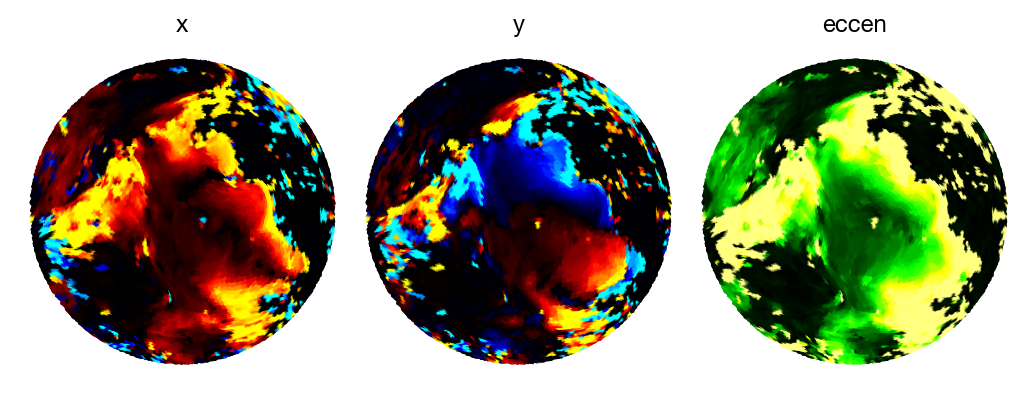

In [25]:
# Let's go ahead and plot the x, y, and eccentricity values.

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,3, figsize=(7,7/3), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)
for (ax,p,name) in zip(axs, [x,y,eccen], ['x','y','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
ny.cortex_plot(fmap, underlay=None, color=x, axes=axs[0],
               cmap='temperature_dark', vmin=-7, vmax=7)
ny.cortex_plot(fmap, underlay=None, color=y, axes=axs[1],
               cmap='temperature_dark', vmin=-7, vmax=7)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[2],
               cmap='greenish_dark', vmin=0, vmax=7)

pass

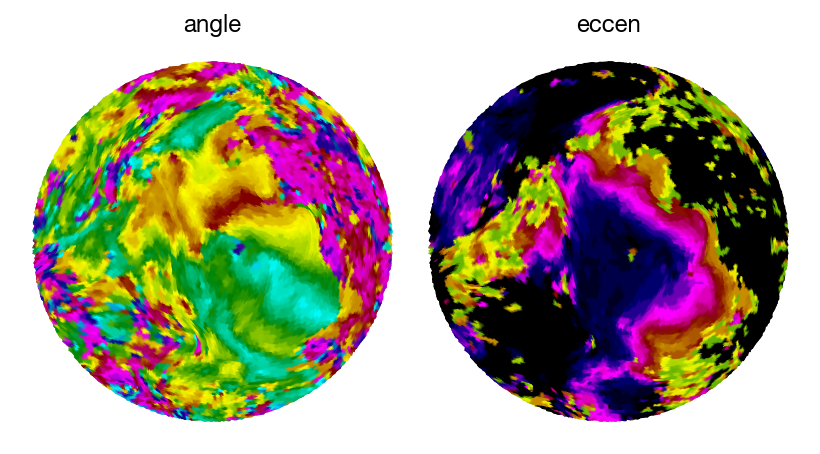

In [26]:
# The borders are generally easier to see when we plot the polar
# angle and eccentricity.

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)
for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)
pass

### Plot the Initial Labels

In order to begin any procedure that attempts to solve the labeling problem, we will likely need a reasonable guess from which to start a search. We can use the anatomical template of retinotopy to do this.

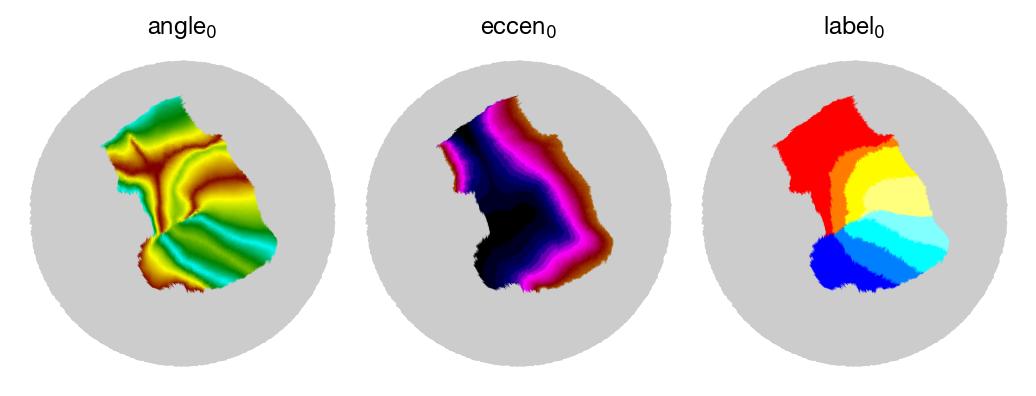

In [29]:
# Let's plot these labels with the polar angle and eccentricity maps.
# These are predicted maps based on anatomy, so are not necessarily
# accurate for the subjet we are looking at.

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,3, figsize=(7,7/3), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)
for (ax,name) in zip(axs, [r'angle$_0$',r'eccen$_0$',r'label$_0$']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)

# Get the polar angle and eccentricity data.
pred = ny.vision.predict_retinotopy(hemi, sym_angle=True)
angle0 = pred['angle'][fmap.labels]
eccen0 = pred['eccen'][fmap.labels]
    
mask = (np.abs(label0), 0, np.inf)
ny.cortex_plot(fmap, underlay='0.8', color=angle0, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180, mask=mask)
ny.cortex_plot(fmap, underlay='0.8', color=eccen0, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90, mask=mask)
ny.cortex_plot(fmap, underlay='0.8', color=label0, axes=axs[2],
               cmap='temperature', vmin=-4, vmax=4, mask=mask)
pass

/Users/nben/Applications/Anaconda3/envs/nben/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


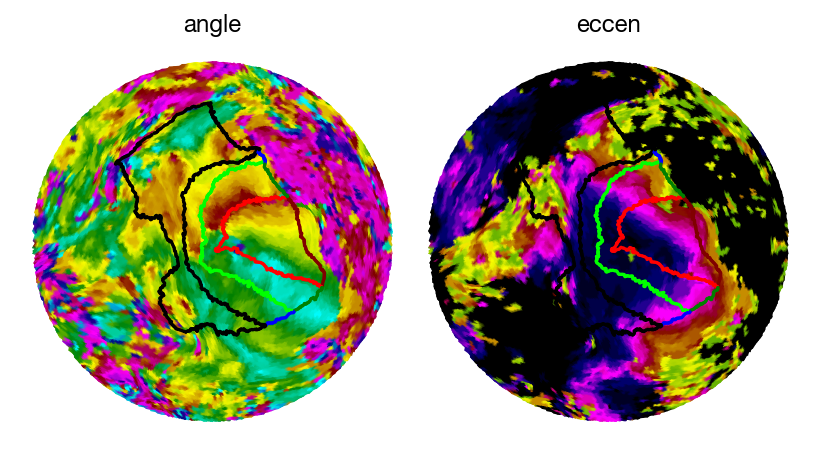

In [31]:
# We might also want to be able to plot the boundaries of the V1/V2/V3
# areas on the actual measued visual field coordinates:

# To plot where the label boundaries are, we plot points in the middle
# of the edges that straddle the boundaries. We can plot them in 
# different colors for different boundaries:
boundary_colors = {(1,2): (1,0,0), (0,1): (0.5,0,0),
                   (2,3): (0,1,0), (0,2): (0,0.5,0),
                   (3,4): (0,0,0), (0,3): (0,0,1),
                   (0,4): (0,0,0)}
(u,v) = fmap.tess.indexed_edges
boundary = np.abs(label0[u]) != np.abs(label0[v])
boundary_u = u[boundary]
boundary_v = v[boundary]
boundary_lbl = [tuple(sorted([np.abs(label0[uu]), np.abs(label0[vv])]))
                for (uu,vv) in zip(boundary_u, boundary_v)]
boundary_clr = [boundary_colors[lbl] for lbl in boundary_lbl]
boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                           fmap.coordinates[:,boundary_v]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.scatter(boundary_coords[0], boundary_coords[1],
               c=boundary_clr, s=0.5)
pass

### Plots of the Scoring Function

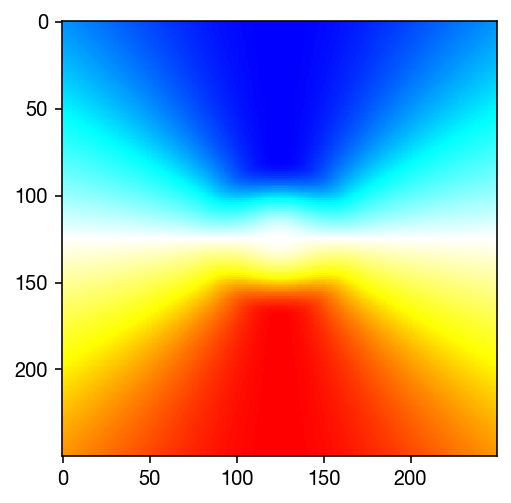

In [187]:
# The score function in question:
def scorefn(x, y, maxecc, fovecc):
    xy = np.asarray([x,y], dtype=np.float32)
    return score_angdist(xy, xy, 0.0, fovecc, 1)
# maximum eccentricity
max_eccen = 7.0
fov_eccen = 0.4
# We're using logeccen space:
trf = lambda x: ny.to_logeccen(x, vmax=14)
tmaxecc = trf(max_eccen)
tfovecc = trf(fov_eccen)
# We make a grid of points, in logeccen space:
pts = np.linspace(-tmaxecc, tmaxecc, 250, dtype='float32')
(x,y) = np.meshgrid(pts, pts)
# Calcuate the score of each pair...
im = np.reshape(
    list(map(lambda x,y: scorefn(x,y,tmaxecc,tfovecc),
             x.flatten(), y.flatten())),
    x.shape)
plt.imshow(im, vmin=0, vmax=2, cmap='temperature')

### Test the Scoring Function

The idea behind the random-walk approach is that we can randomly permute the vertices along the label boundaries then re-evaluate them according to a score that represents our constraints.

A simple approach, in which we first construct a score function then run a random search using it, is detailed here.

In [46]:
# An example: score the starting guess labels.
(u,v) = fmap.tess.indexed_edges
score0 = score_labels(u, v, label0, xy)
score0

14493.554527050586

In [47]:
# What is the change if we swap label 100 to a 0?
nei = fmap.tess.indexed_neighborhoods
delta_sc = score_change(nei, label0, xy, 100, 0, max_eccen)
delta_sc

736.76708984375

### Test the Search Function

Here we run a test of the search function itself. To do this, we run simulated annealing on parallel processes with different random seeds (a single round of annealing) and keep only the label-set from all processes that has the lowest score. We repeat this for several rounds.

In [48]:
# Test the autolabel_anneal() function.
nsteps = 10000
# Copy the initial labels.
label = np.array(label0)
t0 = time.time() # start time
score = autolabel_anneal(fmap, label, xy, nsteps=nsteps)
t1 = time.time() # end time

# Print a message about the time elapsed:
dt = t1 - t0
m = int((dt - np.mod(dt, 60)) / 60)
s = dt - m*60
msperstep = dt / nsteps * 1000
print('%d steps taken in %dm, %05.2fs (%05.3f ms / step).' % (nsteps, m, s, msperstep))

10000 steps taken in 0m, 20.00s (2.000 ms / step).


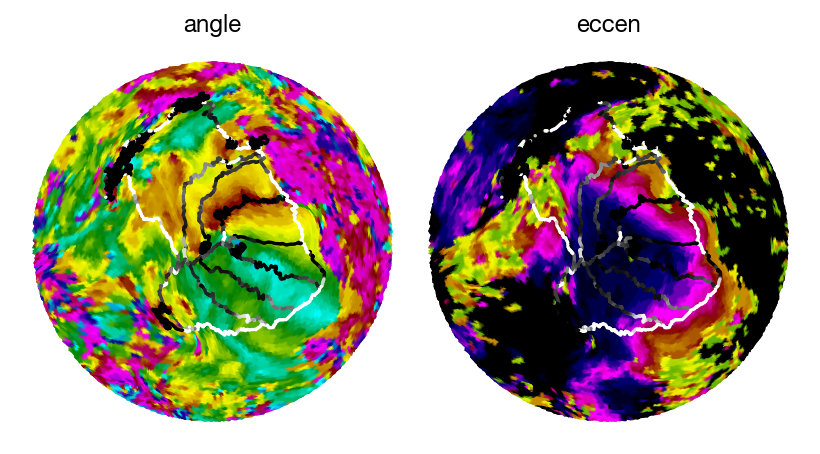

In [52]:
# Plot the result of the above steps:
boundary = label[u] != label[v]
boundary_u = u[boundary]
boundary_v = v[boundary]
boundary_lbl = [tuple(sorted([label[uu], label[vv]]))
                for (uu,vv) in zip(boundary_u, boundary_v)]
boundary_scores = [score_pair(label[uu], label[vv], xy[uu], xy[vv], max_eccen)
                   for (uu,vv) in zip(u[boundary],v[boundary])]
boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                           fmap.coordinates[:,boundary_v]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.scatter(boundary_coords[0], boundary_coords[1],
               s=0.5, c=boundary_scores, cmap='gray', vmin=0, vmax=5)
pass

### Test Simulated or Gold-Standard Examples

In [17]:
# Pick a subject and get the initial prediction
sid = example_sids[0]
# We will use one of the subject's hemisphere's (eigher lh or rh).
h = 'lh'
# Other options for how we score things:
max_eccen = 7.0
fov_eccen = 0.4
log_tr = True

# We prepare the data first.
fmap = initialize_fmap(sid, h, size=1, include_fov=False)
hemi = fmap.meta_data['source_hemi']
# The initial Label
label0 = np.array(fmap.prop('label0'))

# Standard polar angle/eccen and
eccen = fmap.prop('prf_eccentricity')
angle = fmap.prop('prf_polar_angle')
xy = np.array(fmap.prop('prf_center'))
(x,y) = xy.T

# Benson2014-Predicted polar angle and eccen
pred = ny.retinotopy_data(fmap, 'b14_')
angle0 = pred['polar_angle']
eccen0 = pred['eccentricity']
(x0,y0) = ny.as_retinotopy(pred, 'geographical')
xy0 = np.transpose([x0,y0])

# If using log-transform, transform:
trfn = lambda x: ny.to_logeccen(x, vmax=2*max_eccen)
txy = (trfn(xy) if log_tr else xy).astype('float32')
txy0 = (trfn(xy0) if log_tr else xy0).astype('float32')
tmaxecc = trfn(max_eccen) if log_tr else maxecc
tfovecc = trfn(fov_eccen) if log_tr else fovecc

In [21]:
# Get the scores of the boundary:
#(u,v,sc) = score_all_pairs(fmap, label, txy, maxecc=tmaxecc, fovecc=tfovecc)
(u0,v0,sc0) = score_all_pairs(fmap, label0, txy0, maxecc=tmaxecc, fovecc=tfovecc)

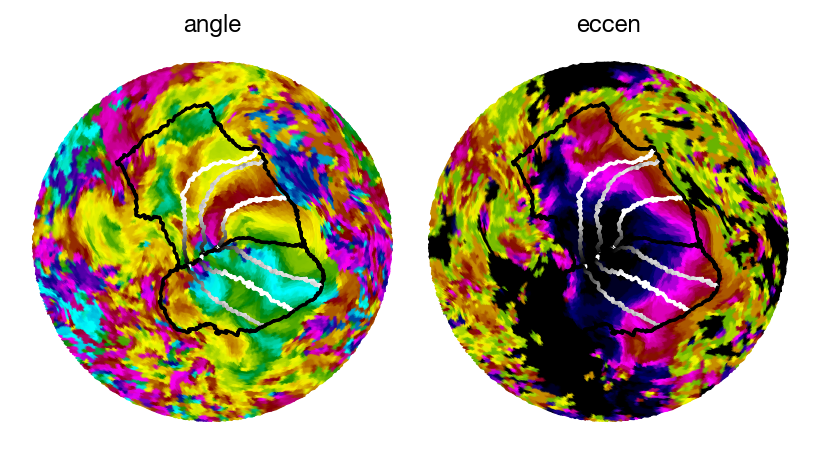

In [28]:
(uu,vv,ss) = (u0, v0, sc0)
# Find the boundary points:
boundary_coords = np.mean([fmap.coordinates[:,uu],
                           fmap.coordinates[:,vv]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.scatter(boundary_coords[0], boundary_coords[1],
               s=0.5, c=ss, cmap='gray', vmin=0, vmax=1)
pass

## Execute the Search with Simulated Annealing

At this point, we have defined a scoring function as well as a function for running random steps of a minimization and for performing simulated annealing using this random-step function. Because this is fundamentally a random search, we will need to run a lot of steps to find a good solution. To speed things up, we can run several processes of simulated annealing at once using the sharedmem package.

### Setup the Subject Data

In [207]:
# Which example subejct to use?
sid = example_sids[3]
# We will use one of the subject's hemisphere's (eigher lh or rh).
h = 'lh'

# We prepare the data first.
fmap = initialize_fmap(sid, h, size=1, include_fov=False, include_v4=False)
hemi = fmap.meta_data['source_hemi']
# Note that the numba functions need read-write arrays for some
# reason; we just make copies before doing any search.
xy = np.array(fmap.prop('prf_center'))
label0 = np.array(fmap.prop('label0'))

(x,y) = xy.T
eccen = fmap.prop('prf_eccentricity')
angle = fmap.prop('prf_polar_angle')

(u,v) = fmap.tess.indexed_edges

# In the HCP retinotopy experiment, the stimulus was 16° wide (so 8° of
# eccentricity, maximum); we will treat 7° of eccentricity as the max
# we want to include because there are edge-effects approaching the 8°
# point.
max_eccen = 7

INFO:root:HCP Dataset: Interpolating retinotopy for HCP subject 115017 / lh (method: nearest)...
INFO:root:HCP Dataset: Interpolating retinotopy for HCP subject 115017 / lh (method: nearest)...
INFO:root:HCPRetinotopyDataset: Loading subjects from file /Users/nben/Data/HCP/subjects/prfresults.mat...
INFO:root:HCPRetinotopyDataset: Loading split 0 from file prfresults.mat...
INFO:root:HCP Dataset: Interpolating retinotopy for HCP subject 115017 / lh (method: nearest)...
INFO:root:HCP Dataset: Interpolating retinotopy for HCP subject 115017 / lh (method: nearest)...
INFO:root:HCP Dataset: Interpolating retinotopy for HCP subject 115017 / lh (method: nearest)...


### Run the Simulated Annealing Rounds

In [216]:
import multiprocessing

# The number of annealing jobs/cpus to use.
nprocs = multiprocessing.cpu_count()
# The number of simulated-annealing rounds to run.
nrounds = 2
# The number of annealing threads in each round
nthreads = 2*nprocs
# The number of steps in each round.
nsteps = 20000
# The min and max annealing speeds.
annealing_speed = (0.25, 4)
# The max best_of value.
max_best_of = 512
# The boundary is ramped up over the annealing rounds to this value. 
max_boundary_weight = 0.0
# The max eccentricity.
maxecc = 7.0
# The foveal eccentricity
fovecc = 0.4

# Before we start, we want to convert xy to be on a log-scale; this is
# because eccentricity is exponentially-spaced in the visual field
# relative to its spacing on cortex, so this generally improves the
# ability of the minimizations to deal with low-eccentricity values.
logsc     = 1
logxy     = np.full(xy.shape, logsc) * ny.to_logeccen(xy, vmax=14)
logmaxecc = logsc * ny.to_logeccen(maxecc, vmax=14)
logfovecc = logsc * ny.to_logeccen(fovecc, vmax=14)
logxy = logxy.astype('float32')

# We keep the pair_weight as 1 at all times
pair_weight = 1

# We will keep track of the minimum label configuration we've found as we go.
(u,v) = fmap.tess.indexed_edges
init_score = score_labels(u, v, label0, logxy,
                          maxecc=logmaxecc, fovecc=logfovecc,
                          boundary_weight=max_boundary_weight,
                          pair_weight=pair_weight)
min_label = np.array(label0)
min_labels = [np.array(label0)] * nthreads
min_scores = [init_score] * nthreads
min_score = init_score
# We define this function for the annealing processes to run:
seed0 = hash(time.time())
def anneal_job(arg, seed=None):
    (lbls, boundary_weight, speed) = arg
    if seed is None:
        seed = seed0 + os.getpid()
    random.seed(seed)
    # lbls = np.array(lbls) # not really necessary in this implementation
    score = autolabel_anneal(fmap, lbls, logxy, nsteps=nsteps,
                             annealing_speed=speed,
                             max_best_of=max_best_of,
                             maxecc=logmaxecc, fovecc=logfovecc,
                             boundary_weight=boundary_weight,
                             pair_weight=pair_weight)
    return (score, lbls)
# These are the annealing speeds we will use
speeds = np.linspace(annealing_speed[0], annealing_speed[1], nrounds)
# We are going to run a number of parallel annealing rounds.
t0 = time.time()
for (roundno,speed) in enumerate(speeds):
    # Recalculate the boundary weight for this annealing round.
    if nrounds == 1: boundary_weight = max_boundary_weight
    else: boundary_weight = roundno * max_boundary_weight / (nrounds-1)
    # because we've changed the boundary_weight, we need to recalculate the min score
    score0 = min_score
    score0s = np.array(min_scores)
    # Print a progress message.
    print('Running parallel-annealing round %d: ' % (roundno + 1,))
    print( '  * speed: %-6f  weight: %s' % (speed, [pair_weight, boundary_weight]))
    print( '  * best min score: %-5.2f' % (100 * min_score/init_score,))
    tmp = ' '.join(['%6.2f']*nthreads)
    tmp = tmp % tuple([100 * msc / init_score for msc in min_scores])
    print('  * all min scores: [' + tmp + ']')
    # In parallel, we do the simulated annealing
    args = [(minlbl, boundary_weight, speed) for minlbl in min_labels]
    with multiprocessing.Pool(nprocs) as pool:
        results = pool.map(anneal_job, args)
    # Of the results, which did the best?
    for (ii,(rscore,labels)) in enumerate(results):
        # the score isn't actually useful because we are slowly
        # adjusting the boundary_weight, so rescore this
        score = score_labels(u, v, labels, logxy, maxecc=logmaxecc, fovecc=logfovecc,
                             boundary_weight=max_boundary_weight,
                             pair_weight=pair_weight)
        min_scores[ii] = score
        min_labels[ii][:] = labels
        if score >= min_score: continue
        min_score = score
        min_label[:] = labels
    reduced_pcts = tuple(
        [100 * (sc0 - msc) / init_score
         for (msc,sc0) in zip(min_scores,score0s)])
    rstr = ' '.join(['%6.2f'] * nthreads) % tuple(reduced_pcts)
    print('  * scores reduced: [' + rstr + '] %')
t1 = time.time()

# Print a message about elapsed time.
dt = t1 - t0
m = int((dt - np.mod(dt, 60)) / 60)
s = dt - 60*m
nstepstot = (nprocs * nsteps * nrounds) * 1000
msperstep = dt / nstepstot
print()
print('%d steps taken in %dm, %05.2fs (%6.4f ms / step).' % (nstepstot, m, s, msperstep))
dscore = min_score - init_score
print('Score Change: %f%% (%6.4f%% per second; %05.3f%% per step).' % (
    100 * dscore/init_score, 100*dscore/init_score/dt, 100*dscore/init_score/nstepstot))

label = min_label

Running parallel-annealing round 1: 
  * speed: 0.250000  weight: [1, 0.0]
  * best min score: 100.00
  * all min scores: [100.00 100.00 100.00 100.00 100.00 100.00 100.00 100.00]
  * scores reduced: [ 32.54  33.52  33.44  32.94  31.67  32.84  32.80  33.52] %
Running parallel-annealing round 2: 
  * speed: 4.000000  weight: [1, 0.0]
  * best min score: 66.48
  * all min scores: [ 67.46  66.48  66.56  67.06  68.33  67.16  67.20  66.48]
  * scores reduced: [  5.33   3.20   2.21   3.22   4.65   3.85   4.55   3.84] %

160000000 steps taken in 29m, 02.91s (0.0000 ms / step).
Score Change: -37.872725% (-0.0217% per second; -0.000% per step).


/Users/nben/Applications/Anaconda3/envs/nben/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


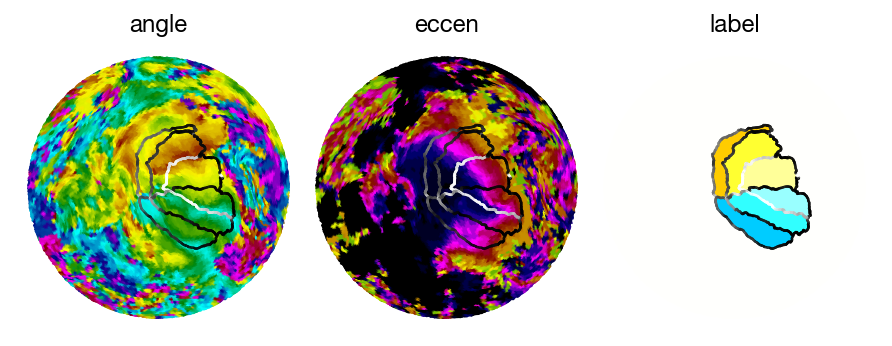

In [217]:
# Plot the result of the above steps:
min_label = results[1][1]
boundary = min_label[u] != min_label[v]
boundary_u = u[boundary]
boundary_v = v[boundary]
boundary_lbl = [tuple(sorted([label[uu], label[vv]]))
                for (uu,vv) in zip(boundary_u, boundary_v)]
boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                           fmap.coordinates[:,boundary_v]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,3, figsize=(6,2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

#ny.cortex_plot(fmap, underlay=None, color=logxy[:,0], axes=axs[0],
#               cmap='temperature', vmin=-logmaxecc, vmax=logmaxecc)
#ny.cortex_plot(fmap, underlay=None, color=logxy[:,1], axes=axs[1],
#               cmap='temperature', vmin=-logmaxecc, vmax=logmaxecc)
ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)
ny.cortex_plot(fmap, underlay=None, color=min_label, axes=axs[2],
               cmap='temperature', vmin=-5, vmax=5)

for (ax,name) in zip(axs, ['angle','eccen','label']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    # color the points by their pairwise scores
    clrs = [score_pair(min_label[uu], min_label[vv], logxy[uu], logxy[vv], logmaxecc, logfovecc)
            for (uu,vv) in zip(boundary_u, boundary_v)]
    ax.scatter(boundary_coords[0], boundary_coords[1],
               c=clrs, s=0.1, cmap='gray', vmin=0, vmax=1.5)

pass

### Compare Results to the Ground Truth

The ground-truth data can be found on this OSF website: [https://osf.io/gqnp8/?view_only=14135b01768a404b8eaf8a069bacc8fb](https://osf.io/gqnp8/?view_only=14135b01768a404b8eaf8a069bacc8fb).

You should be able to click on the files section and download the directory `visual_area_labels` as a zip file. Once you've done this, unzip the zip file into a directory that you can find from your notebook. We will load them using the `ny.load(filename)` function, which will yield a vector of labels, one per vertex. However, note that these vertices will be one per label of the entire hemisphere, not one per label of the flattened meshes we've been using to plot. The difference between the entire hemisphere and the flatmap is small: both are triangle meshes, but the entire hemisphere is a 3D mesh with 3D vertex coordinates while the flatmap is a 2D mesh. Additionally, the flatmap contains only some of the vertices in the entire hemisphere. You can see which by looking at `fmap.labels`.

In [ ]:
# Load in the ground-truth for just the LH of the subject we've been using in
# the minimizations above
# (sid is the subject ID and h is the hemisphere ('lh' or 'rh'))
true_labels = ny.load(os.path.join('visual_area_labels', '%s.%d_varea.mgz' % (h, sid)))
true_labels = true_labels[fmap.labels]

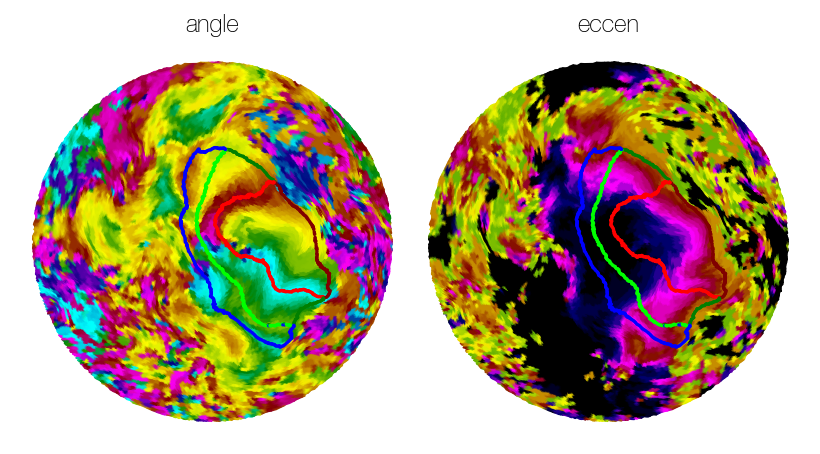

In [56]:
# Here we plot the true_labels, using the same boundary_colors we used earlier.

# Find the boundary using the true labels:
boundary = true_labels[u] != true_labels[v]
boundary_u = u[boundary]
boundary_v = v[boundary]
boundary_lbl = [tuple(sorted([true_labels[uu], true_labels[vv]]))
                for (uu,vv) in zip(boundary_u, boundary_v)]
boundary_clr = [boundary_colors[lbl] for lbl in boundary_lbl]
boundary_coords = np.mean([fmap.coordinates[:,boundary_u],
                           fmap.coordinates[:,boundary_v]],
                          axis=0)

# Setup the matplotlib/pyplot figure.
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

ny.cortex_plot(fmap, underlay=None, color=angle, axes=axs[0],
               cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, underlay=None, color=eccen, axes=axs[1],
               cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.scatter(boundary_coords[0], boundary_coords[1],
               c=boundary_clr, s=0.5)
pass

In [57]:
# In order to compare the true labels with the predicted labels, we need
# to use a metric sometimes called the "dice coefficient" or the "bray-curtis
# dissimilarity":
# https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity
# (they are basically the same thing)
def dice_score(true_labels, pred_labels, visual_areas=[1,2,3]):
    '''
    dice_score(labels1, labels2) yields the Sørensen-Dice coefficient of the
      label vectors `labels1` and `labels2`. The labels must both be vectors
      of equal length, each of which contains integer labels. Labels with
      the value 0 are excluded.
      
    The optional argument `visual_areas` (default: `[1,2,3]`) may be given in
    order to instruct the dice_score to focus on only a subset of the labels.
    For example, to get the Dice coefficient for V1 only, you can use the
    call `dice_score(labels1, labels2, visual_areas=[1])`. By default, this
    option includes V1, V2, and V3; the return value is the the number of
    vertices in the two labelsets that are equal divided by the number of
    vertices (with vertices in both sets that are 0 excluded).
    '''
    vas = np.array([visual_areas]) if pimms.is_int(visual_areas) else np.asarray(visual_areas)
    # the included indices
    ii = np.where(np.isin(true_labels, vas) | np.isin(pred_labels, vas))[0]
    true_labels = true_labels[ii]
    pred_labels = pred_labels[ii]
    return np.sum(true_labels == pred_labels) / len(ii)

In [58]:
# Get the overall score for the prediction we ran earlier:
dice_score(true_labels, labels)

0.7782667155604449

### Cleaning the Maps

Given a set of labels (as we found in the section above), we can use tools built into neuropythy to clean the retinotopic maps; this reduces the noise dramatically.

In [154]:
# Convert the labels for the flatmap into labels for the hemisphere
hemi_label = np.zeros(hemi.vertex_count, dtype='int')
hemi_label[fmap.labels] = min_label
# Perform the cleaning; output it as polar_angle and eccentricity
cl = ny.vision.clean_retinotopy(hemi, 'prf_', visual_area=hemi_label,
                                output_style='visual')
(clean_angle, clean_eccen) = cl

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


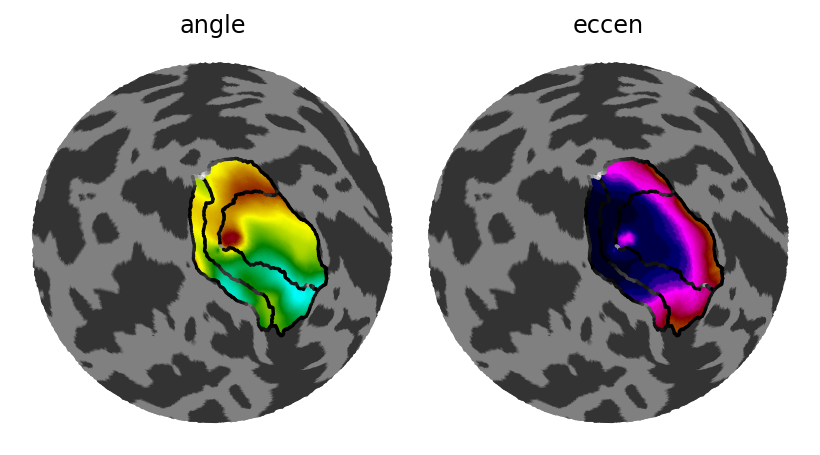

In [155]:
# Plot the result of the above steps; setup the matplotlib/pyplot figure:
(fig,axs) = plt.subplots(1,2, figsize=(5.5,5.5/2), dpi=144)
fig.subplots_adjust(0,0,1,1,0,0)

mask = (min_label, (1,2,3))
ny.cortex_plot(fmap, color=clean_angle[fmap.labels], axes=axs[0],
               mask=mask, cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fmap, color=clean_eccen[fmap.labels], axes=axs[1],
               mask=mask, cmap='eccentricity', vmin=0, vmax=90)

for (ax,name) in zip(axs, ['angle','eccen']):
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(name)
    # color the points by their pairwise scores
    clrs = [score_pair(min_label[uu], min_label[vv], logxy[uu], logxy[vv], logmaxecc)
            for (uu,vv) in zip(boundary_u, boundary_v)]
    ax.scatter(boundary_coords[0], boundary_coords[1],
               c=clrs, s=0.5, cmap='gray')

pass

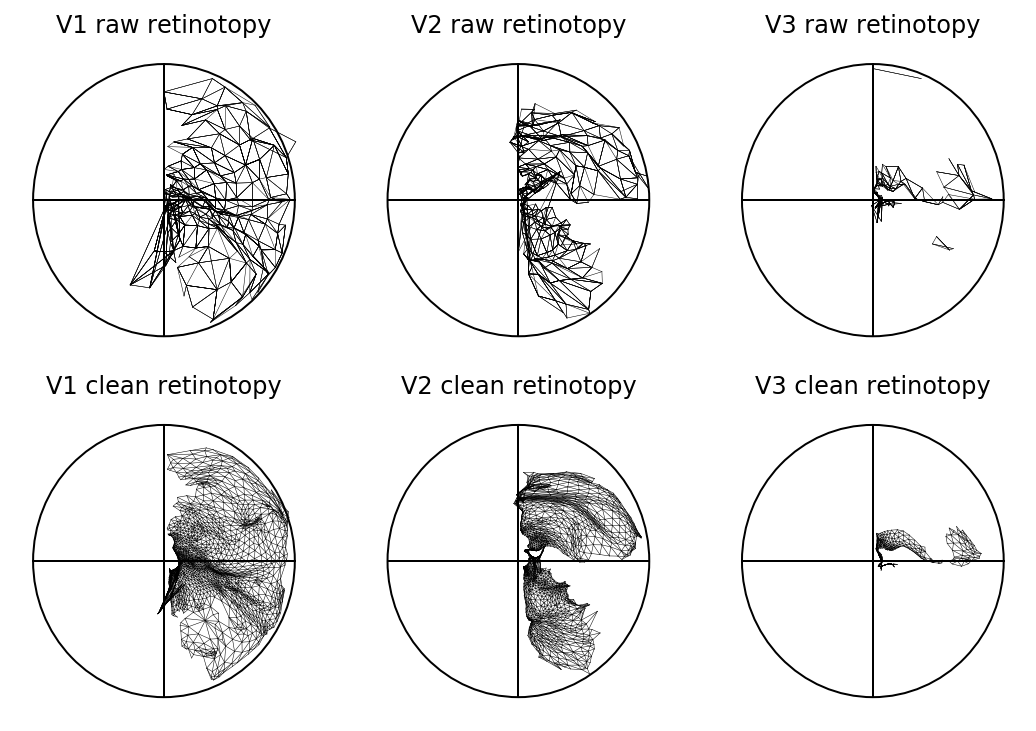

In [156]:
(fig,axs) = plt.subplots(2,3, figsize=(7,7*2/3), dpi=144)
fig.subplots_adjust(0,0,1,1,0.185,0.16)
for ax in axs.flatten():
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    ax.add_patch(plt.Circle([0,0],7, fill=False, edgecolor='k', lw=1))
    ax.plot([-maxecc,maxecc],[0,0],'k-',lw=1)
    ax.plot([0,0],[-maxecc,maxecc],'k-',lw=1)
    ax.axis('off')
clean_xy = ny.as_retinotopy({'polar_angle':clean_angle,
                             'eccentricity':clean_eccen},
                            'geographical')
clean_xy = np.asarray(clean_xy)
for (viscoords,axrow,name) in zip([xy.T, clean_xy[:,fmap.labels]], axs, ['raw', 'clean']):
    for (varea,ax) in zip([1,2,3],axrow):
        mask = fmap.mask((min_label, varea), indices=True)
        submesh = fmap.submesh(mask)
        mask = fmap.tess.index(submesh.labels)
        vismesh = submesh.copy(coordinates=viscoords[:,mask])
        ax.plot(vismesh.edge_coordinates[:,0], vismesh.edge_coordinates[:,1],
                'k-', lw=0.25)
        ax.set_title('V%d %s retinotopy' % (varea, name))

Thoughts: Use lines plus scores to come up with probability distribution of possible solutions given a set of lines. I.e., the lines drawn by the raters are "correct" so we can look at scores... etc.


### Prior

In [9]:
# Align all subjects' labels into fsaverage
import pandas as pd
sids = ny.data['hcp_retinotopy'].subject_ids
fsa = ny.freesurfer_subject('fsaverage')
for h in ['lh', 'rh']:
    fshm = fsa.hemis[h]
    df_fsa = pd.DataFrame([], columns=range(len(fshm.labels)))
    #Iterate all sbujects
    for i in range(181):
        sid = sids[i]
        sub = ny.hcp_subject(sid)
        path = os.path.join('visual_area_labels', '%s.%d_varea.mgz' % (h, sid))
        if not os.path.isfile(path):
            continue
        else:
            hemi = sub.hemis[h]
            labels = ny.load(path)
            labels_interpolated = hemi.interpolate(fshm, labels, method='nearest')
            df_fsa = df_fsa.append([labels_interpolated])
    df_fsa.to_csv(str(h)+'_label_'+'fsa.csv', header = True)

In [ ]:
# Calculate the probability that a particular vertex is in V1, V2, or V3 (has label 1, 2, or 3)
for h in ['lh', 'rh']:
    df_fsa = pd.read_csv(str(h) + '_label_' + 'fsa.csv', header=None, skiprows=[0])
    df_count = df_fsa.apply(pd.value_counts)
    label_prob_fsa = df_count/len(df_fsa)
    label_prob_fsa = label_prob_fsa.fillna(0)
    label_prob_fsa.to_csv(str(h) + '_label_prob_fsa.csv')